RFM + Acquisition time. (Common literature - just limited to RFM)

Draw a cover pic kind of Picture: 
    Data Processing - removing outliers - Comparing clustering algorithms - Interpreting Clusters - Possible Actionables - Tricky FAQ's

Can you draw an image as cover pic which summarises what all you did?

I have covered how to go about constructing important features, cluster customers, automate tagging and direction for actionables.

Given limited data and paucity of time the model is a baseline model and have tried to discuss possible future work and answer some very crucial QnA.

# Summary

Index

Communication strategy Matrix! 

Price, Availability, Customer service (ease of billing, ease of ordering etc.), unavailable with the competition
a . Whom should you give discounts ? What type of discounts ? should it be on specific items ? If yes then which one? - interest
b.  How can you Nudge customers with communication?
    what should be the communication strategy?

    

Questions? Targeted Customer Communication
1. Customer based on Clustering customers based on frequency, recency, value !
2. Customers expected to give most business in coming days ?  --- Need to be target with Availability and fresh pieces of their favourite items
3. Customers at the risk of attrition? -- Need to be Nudged with discounts in their favourite/recent bought item
4. Customers whose recency has dropped compared to past! 
5. Current Projected sales !!  Nudge them, yay ?
6. Quantity of articles - They are all mostly wholesalers! Nudge with the quantity of most selling product.
7. Suggestion bas



# Objectives

1. Segmenting and understanding current customer base
2. Identifying at risk high value customers
3. Identifying loyal, high value customers
4. Come up with a targeted marketing stratgy


Type of customers: Actions
Customer Centric Communications:

    

In [3]:
# retail.Country.value_counts()

#### Brief Sentiyapa

# Business Questions?

# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

#Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
retail = pd.read_excel('online_retail_II.xlsx')

In [5]:
retail.shape

(525461, 8)

In [6]:
retail.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

### Cleaning

In [8]:
# Deleting cancelled orders with 'C' as prefix in the invoice
# retail.Invoice.astype(str).str[0].value_counts() 
retail_1 = retail[~pd.Series(retail.Invoice.astype(str).str[0] == 'C')]

# Deleting Missing Customer IDs, since we are interested in customer segmentation
retail_1 = retail_1.dropna(subset = ['Customer ID'])

# Deleting Rows with Zero price
retail_1 = retail_1[retail_1['Price']>0]

#Deleting Rows with Zero Quantity
retail_1 = retail_1[retail_1['Quantity']>0]

# Filtering out transactions which do not belong to United Kingdom
retail_1 = retail_1[retail_1['Country'] == 'United Kingdom']

In [9]:
retail_1.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [10]:
retail_1.shape

(370929, 8)

Creating A column for Amount spend = Price*Quantity

In [11]:
retail_1.loc[:,'Amount'] = retail_1.loc[:,'Quantity']*retail_1.loc[:,'Price']

In [12]:
retail_1.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


### Invoice level summary

In [13]:
 retail_2 = retail_1.groupby('Invoice').aggregate({'InvoiceDate': max, 'Amount': np.sum, 'Description': 'nunique',
                                                 'Customer ID': max})

In [14]:
retail_2.head(2)

,InvoiceDate,Amount,Description,Customer ID
Invoice,,,,
489434,2009-12-01 07:45:00,505.3,8,13085.0
489435,2009-12-01 07:46:00,145.8,4,13085.0


Extracting useful columns from the timestamp for EDA

In [15]:
retail_2['Time'] = retail_2.InvoiceDate.dt.time
retail_2['Date'] = retail_2.InvoiceDate.dt.date
retail_2['DOW'] = retail_2.InvoiceDate.dt.weekday_name
retail_2['Month'] = retail_2.InvoiceDate.dt.month
retail_2['Year'] = retail_2.InvoiceDate.dt.year
retail_2['WOY'] = retail_2.InvoiceDate.dt.week

In [16]:
retail_2['Date'] =  pd.to_datetime(retail_2['Date'])
retail_2.head(2)

,InvoiceDate,Amount,Description,Customer ID,Time,Date,DOW,Month,Year,WOY
Invoice,,,,,,,,,,
489434,2009-12-01 07:45:00,505.3,8,13085.0,07:45:00,2009-12-01,Tuesday,12,2009,49
489435,2009-12-01 07:46:00,145.8,4,13085.0,07:46:00,2009-12-01,Tuesday,12,2009,49


### Feature Engineering

##### Defining New metric - Recency, Frequency, Value, Time since first purchase

Assuming we have to take actions immediately post the most recent date in the data

Recency: Days since the last purchase date in the data i.e 2010-12-09
Frequency: Number of Inovices uptill the last purchase
Time since first purchase: Days since first purchase w.r.t latest purchase in data
Value = Sum of Total amount spend uptill the latest date in the data
    


In [19]:
# Most recent date in the dataset
recent = retail_2.sort_values('Date', ascending =False)['Date'].iloc[0]

# Defining new column day_diff in the Invoice Summary
retail_2['recent'] = recent
retail_2['recent'] = pd.to_datetime(retail_2['recent'])
retail_2['day_diff'] = (retail_2['recent'] - retail_2['Date']).dt.days # used for recency
retail_2['day_diff_2'] = retail_2['day_diff'] # used for days_on_platform calculation
retail_2 = retail_2.reset_index()

# Creating table at the customer level
retail_3 = retail_2.groupby('Customer ID').aggregate({'day_diff': 'min','day_diff_2': 'max', 'Amount': 'sum','Invoice': 'count'})
retail_3 = retail_3.rename(columns = {'day_diff':'Recency','day_diff_2': 'days_on_platform', 'Amount': 'Value', 'Invoice': 'Frequency'})

In [20]:
retail_3.head(2)

,Recency,days_on_platform,Value,Frequency
Customer ID,,,,
12346.0,164,360,372.86,11
12608.0,39,39,415.79,1


### Final Data at Customer Level

In [21]:
retail_3.describe().round()

,Recency,days_on_platform,Value,Frequency
count,3969.0,3969.0,3969.0,3969.0
mean,90.0,226.0,1868.0,4.0
std,97.0,119.0,7381.0,8.0
min,0.0,0.0,3.0,1.0
25%,17.0,120.0,304.0,1.0
50%,51.0,253.0,670.0,2.0
75%,135.0,330.0,1656.0,5.0
max,373.0,373.0,349164.0,155.0


Visualizing Distribution of the constructed features

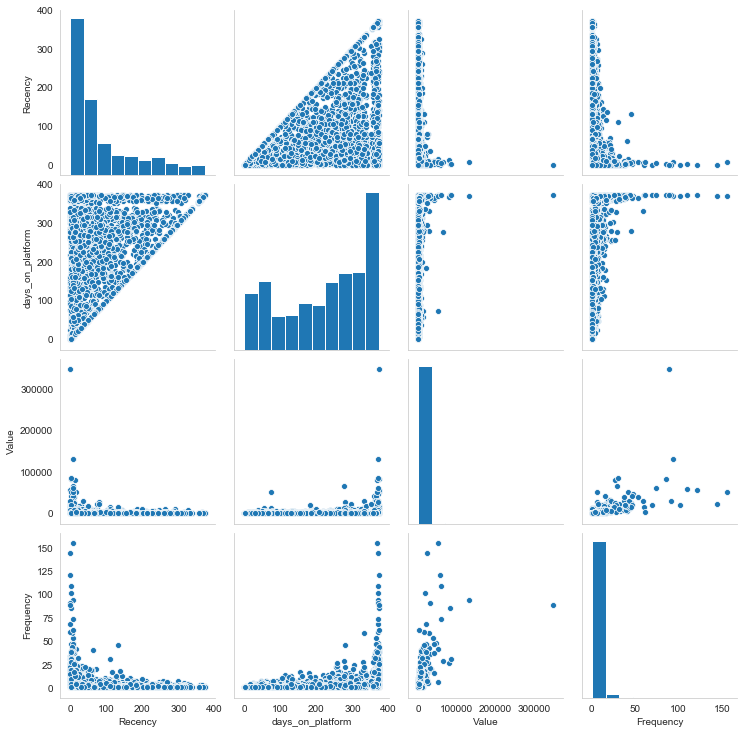

In [101]:
sns.pairplot(data= retail_3)

Variables appear to be highly skewed, majorly because of outliers in the data.
 

# Current Business Snapshot

Time - x axis, y - total sales, Rolling/WoW 7 days active customers, Business / Active customer, Number of Acquired customers with time line. 

# Segmenting Users via Clustering

We will be using Kmeans algorithm for clustering.
Two things to note here:
    1. Kmeans is sensitive to outliers, therfore we will treat the outlier customers seperately
    2. Kmeans is based on euclidian distance, thus its important to standardise all the vairables to bring them on a similar scale

## Treating Anomalies/Outliers

There are many ways to remove outliers. One of the very efficient ways to remove anomalies in a high dimension dataset is Isolation Forest. It works similar to an ensemble of decission trees.

#### Isolation Forest

In [37]:
from sklearn.ensemble import IsolationForest

Contamination is the argument in Isolation Forest which tells the upper cap on the percentage of anomalies in the data. This can be chosen based on domain knowledge or EDA. Using bloxpot on each variable we found around 17% of the data is outier. So we are using 0.15 (i.e 15%) as an argument for Isolation forest. Ofcourse, this can be further optimised post looking the profile of the outliers and the filtered data. 

In [38]:
rng = np.random.RandomState(21)
clf = IsolationForest(max_samples= retail_3.shape[0], random_state=rng, contamination = 0.15)
clf.fit(retail_3)
y_pred = clf.predict(retail_3)

In [39]:
# pd.DataFrame(y_pred).value_counts()
pd.Series(y_pred).value_counts()

 1    3373
-1     596
dtype: int64

**Around 15% of data is removed as anomalies. These 15% of the customers should be treated seperately. They might be very important customers too**

In [40]:
if_retail = retail_3.loc[y_pred == 1,:]

Viewing Pair plots, post removal of the anomalies

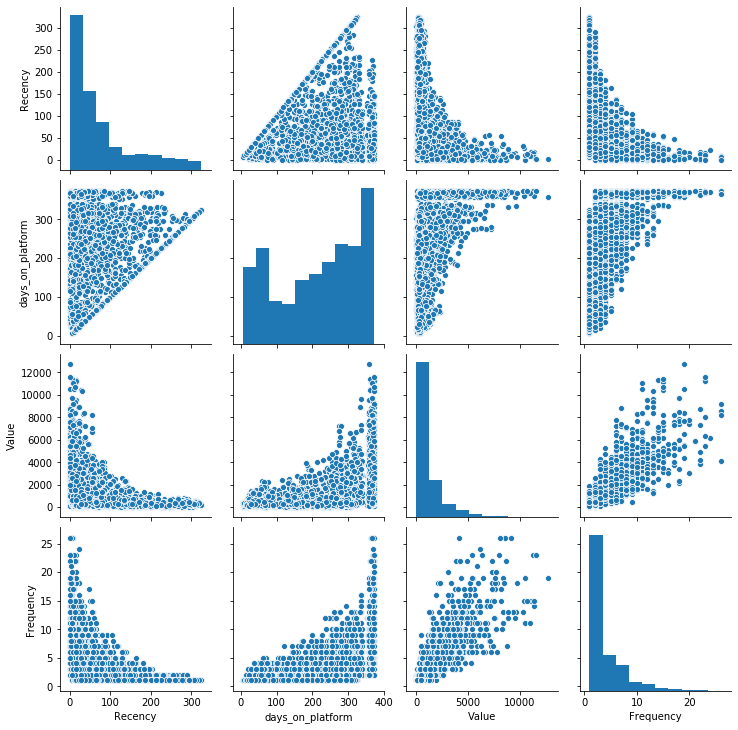

In [41]:
sns.pairplot(if_retail)

**Things to note**
1. Variables have strong relationship with each other. Example Value is positively correlated with frequency. 
2. Recency is almost exponentialy falling, which is good as that means most of the customers are recently active. 
3. Customer acquisition indicated by no. of days on platform is fairly distributed across the timeline. Good thing is there is peak on left side indicating a jump in acquired customers recently. 
4. Value is exponentially decreasing, indicating majority of the customers are low value customers. 
5. Frequency is almost exponentially decreasing indicating majority customers have a low frequency. 

In QnA I have answered what could be the pitfall of clustering on correlated variables and how it can be avoided. 


### Standardising the Variables

Since the variables are on different scale and kmeans uses euclidian distance, we will be standardizing our features for a common scale. 

In [43]:
from sklearn import preprocessing

In [115]:
retail_std =  pd.DataFrame(preprocessing.scale(if_retail), columns = if_retail.columns)

Final Data set

In [120]:
retail_std.head()

,Recency,days_on_platform,Value,Frequency
0,-0.472323,-1.531762,-0.515742,-0.738915
1,0.551133,-0.069002,-0.315505,-0.458906
2,1.225116,-0.361554,-0.620546,-0.738915
3,-0.909164,1.290505,2.516309,3.461221
4,-0.534729,-0.525039,1.038191,0.101112


### Finding the right number of clusters

We will be using two different methods to identify right number of clusters. 
1. Elbow Method:
2. Silhouette Method:

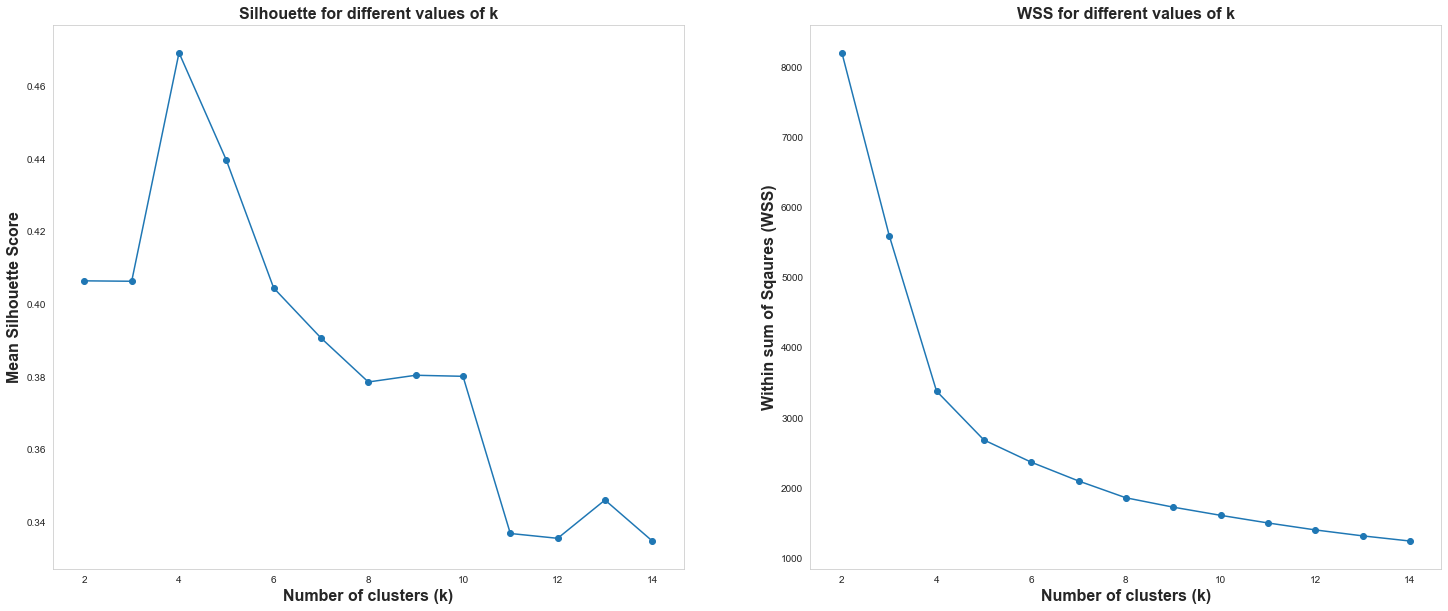

In [127]:
plt.figure(figsize=(25,20))
plt.subplot(2,2,1)

#Plotting mean Silhouette score vs number of clusters
score = np.zeros(15);
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, random_state=21); #Initializing KMeans for different n_clusters
    clus_pred = kmeans.fit_predict(retail_std)  #Clustering using KMeans
    score[i] = silhouette_samples(retail_std, clus_pred).mean()  #Computing SSE

plt.plot(range(2,15),score[2:15])
plt.scatter(range(2,15),score[2:15])
plt.xlabel('Number of clusters (k)', fontsize=16, fontweight='bold')
plt.ylabel('Mean Silhouette Score', fontsize=16, fontweight='bold')
plt.title('Silhouette for different values of k', fontsize=16, fontweight='bold')
plt.show()


plt.subplot(2,2,2)

score = np.zeros(15);
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, random_state=21); #Initializing KMeans for different n_clusters
    kmeans.fit_predict(retail_std)  #Clustering using KMeans
    score[i] = -kmeans.score(retail_std)  #Computing SSE

#Plotting SSE
plt.plot(range(2,15),score[2:15])
plt.scatter(range(2,15),score[2:15])
plt.xlabel('Number of clusters (k)', fontsize=16, fontweight='bold')
plt.ylabel('Within sum of Sqaures (WSS)', fontsize=16, fontweight='bold')
plt.title('WSS for different values of k', fontsize=16, fontweight='bold')
plt.show()    

**Both the elbow method and mean silhouette score points to choosing 4 clusters.**

## Kmeans Clustering

Implementing Kmeans using number of clusters = 4

In [128]:
kmeans = KMeans(n_clusters= 4, random_state= 21); #Initializing KMeans for different n_clusters
cluster_tag = kmeans.fit_predict(retail_std)  #Clustering using KMeans

Visualizing clusters on a silhouette score

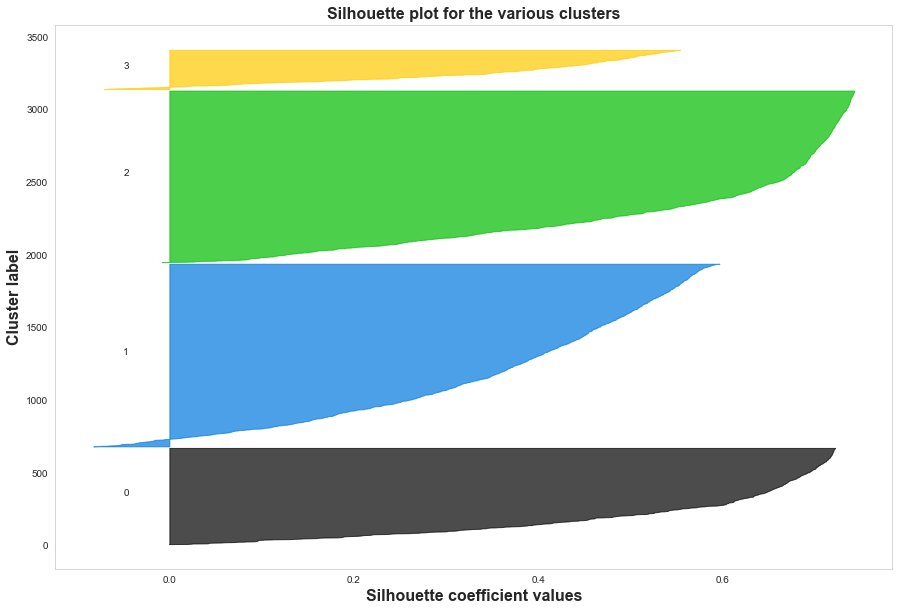

In [135]:
# Defining Function to plot silhouette
def silhouette(X,labels):
    n_clusters=np.size(np.unique(labels));
    sample_silhouette_values=silhouette_samples(X,labels)
    y_lower=10
    plt.figure(figsize=(15,10))
    for i in range(n_clusters):
        ith_cluster_silhouette_values=sample_silhouette_values[labels==i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        color=cm.nipy_spectral(float(i)/n_clusters)
        plt.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)# Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05,y_lower+0.5*size_cluster_i,str(i))#Compute the new y_lower for next cluster
        y_lower=y_upper+10# 10 for the 0 sample
    plt.title("Silhouette plot for the various clusters", fontsize=16, fontweight='bold')
    plt.xlabel("Silhouette coefficient values", fontsize=16, fontweight='bold')
    plt.ylabel("Cluster label", fontsize=16, fontweight='bold')
    plt.show()
    
silhouette(retail_std,cluster_tag)    

Insights?

The above graph shows the silhouette score for each data point. We have a mean silhouette score of 0.46 which is pretty descent and indicate that clusters are meaningful. 

We can definately try using different algorithms to optimise this silhouette score. 

In [68]:
if_retail.head(5)

,Recency,days_on_platform,Value,Frequency,cluster
Customer ID,,,,,
12608.0,39,39,415.79,1,1
12745.0,121,209,723.85,2,3
12746.0,175,175,254.55,1,3
12747.0,4,367,5080.53,16,2
12749.0,34,156,2806.48,4,0


# Interpreting Clusters (Customer Segments)

In [ ]:
Summary of Clusters (Customer Segments)

In [ ]:
Make Box plots For each metric on x and clusters on y, if possible with labelled numbers. 

See if you can show bar plots along with no.s inside the cells. 
If taking time use gradient colours!

In [94]:
if_retail.groupby(['cluster']).describe().T.round(1)

cluster                      0       1        2       3
Recency          count  1258.0  1182.0    271.0   662.0
                 mean     41.7    48.5     16.0   219.1
                 std      33.3    34.3     15.9    53.6
                 min       0.0     0.0      0.0   111.0
                 25%      14.2    21.0      4.0   176.0
                 50%      32.0    42.0     11.0   213.0
                 75%      63.0    69.0     23.0   261.0
                 max     154.0   142.0     81.0   324.0
days_on_platform count  1258.0  1182.0    271.0   662.0
                 mean    301.1    81.6    349.3   244.9
                 std      57.4    53.7     32.4    54.1
                 min     143.0     6.0    235.0   143.0
                 25%     258.0    39.5    337.0   200.0
                 50%     308.0    67.0    364.0   247.0
                 75%     360.0   119.0    370.0   290.0
                 max     373.0   228.0    373.0   372.0
Value            count  1258.0  1182.0    271.0   662.0
                 mean   1477.6   488.7   5243.6   334.2
                 std     867.9   386.7   2103.7   256.1
                 min      43.2     3.8   1958.0     6.3
                 25%     801.1   217.1   3763.0   157.0
                 50%    1318.5   382.5   4660.7   266.5
                 75%    2028.6   629.1   6239.1   422.4
                 max    4722.6  2557.4  12723.2  1779.4
Frequency        count  1258.0  1182.0    271.0   662.0
                 mean      4.7     1.7     12.6     1.4
                 std       2.1     0.9      4.2     0.6
                 min       2.0     1.0      4.0     1.0
                 25%       3.0     1.0     10.0     1.0
                 50%       4.0     1.0     12.0     1.0
                 75%       6.0     2.0     15.0     2.0
                 max      13.0     7.0     26.0     5.0
cluster_avg      count  1258.0  1182.0    271.0   662.0
                 mean      0.0     0.0      1.6     0.0
                 std       0.2     0.0      1.2     0.0
                 min       0.0     0.0      0.0     0.0
                 25%       0.0     0.0      1.0     0.0
                 50%       0.0     0.0      2.0     0.0
                 75%       0.0     0.0      3.0     0.0
                 max       3.0     0.0      3.0     0.0

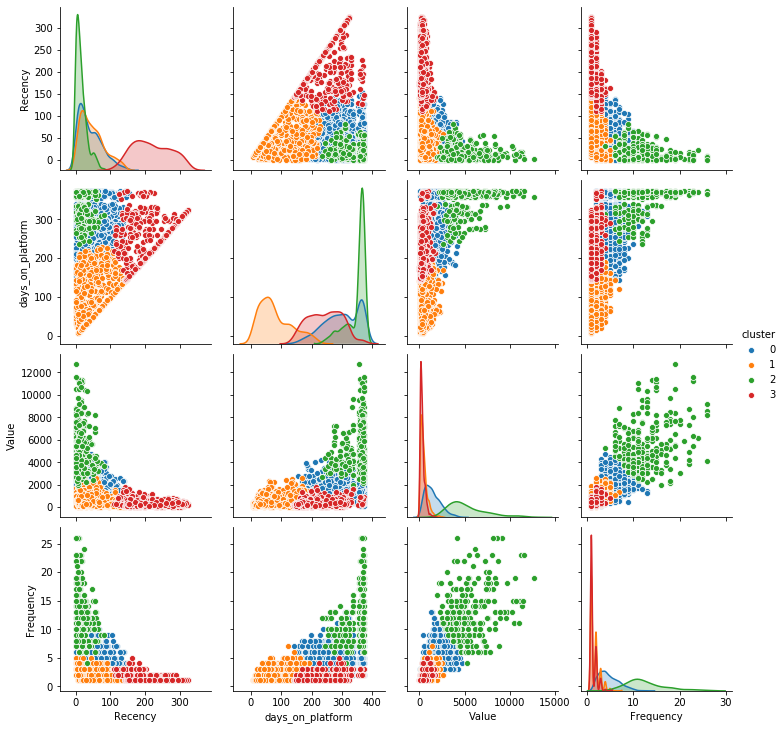

In [73]:
sns.pairplot(if_retail, hue = "cluster")

In [108]:
Plot Table:
    
    Cluster no. ,  RFM Mean values and Range including 90% of the customers

SyntaxError: invalid syntax (<ipython-input-108-7c1e9b9b625a>, line 1)

Insights 

- Red:
Old and inactive
Inactive : Low frequency, old, low value
- Green:
Old and active
Active, high value: High value, frequent, old, recent.
- Yellow:
Recent and less active
- Blue
Medium aged, Medium engaged customers

Table:
Cluster, Proportion of Base, Business Contribution in recent Month, Overall Business Contribution, Naming Segments.Metric summary. 





Visualization
PCA - would be able to comment on the shape of clusters
https://blog.bioturing.com/2018/06/18/how-to-read-pca-biplots-and-scree-plots/  
tells how to read PCA biplots    


Breaking Down cluster into Subcategories
- can use a decision tree as in the paper

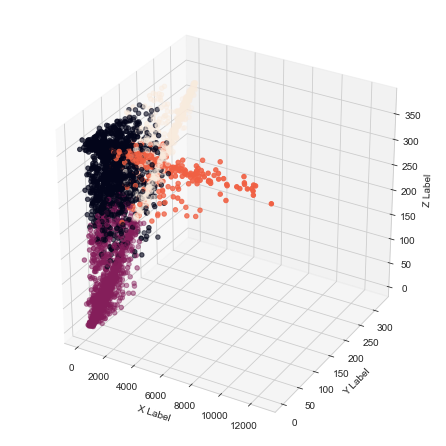

In [75]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = if_retail['Value']
y = if_retail['Recency']
z = if_retail['days_on_platform']

ax.scatter(x, y, z, c= if_retail['cluster'], marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Business Actionables

Summary

Table: Segment Name: Agenda/objective/sub title Actionable

- Make table in excel and put the image here

# Automating Customer Segments

In [ ]:
We can automate identification of customers, by defining logics of comparison based on fixed number of clusters.
Example can be shown here!

*Logics of Automation will have to be periodically revisited!

# Highlights

# Future Work

1. Studying the outlier customers (0.2% of the base). They might be some of the very important customers. 
3. Can play around with definations of RFM with the additional data for ex. for recency ----
4. In the cleaning step we have filtered out rows with prices <= 0 or quantity <= 0. We can also impute these values wherever possible after grouping at the level of other available variables. 
5. Given that we can do targeted personalized communications we increase the clusters and even sub categorize within a cluster as per Need.
6. Detailing into the left out 20% of the customers
7. Playing with weights for the Variables


Automation logics can be more scrutinized taking into account the whole distributions and not just the means.
We can use log transforms on .... and check if we get better clusters (Silhouette can be useful metric to compare)


Given the limited data and paucity of time the case study builds a base model and comrehensively studies the need, way and execution of customer segments for businesses. 

Can make a segmented Table in Tableau and paste it here\
Check how to give a RFM score ! \
Can also make and depict mom or wow cohort movements \ 
If one of the clusters has huge amount, bifurcate it further to make sub categories \ 
Can embed hand sketches of why clustering ?
why noise is crucial to eliminate ?
why standardising?
why silhouette?
Does giving a RFM score helps? In what case does it work, and in what case it doesn't

Executionable insights! 

# QnA

What is RFM score? When do we use it? What are its limitations? Why did we not use the traeditional RFM scoring?

---  was an excel thing! Best customer buckets

Outliers? How do they influence clustering? What are the most commong methods? How do we choose the right one?

alsghl

Why did we not use DBSCAN for clustering, it could have even removed the noise (outliers) itself?

Why did we not use DBSCAN for removing outliers. 

How do you evaluate your clusters?

What to do when we have colinear variables?

https://www.trchome.com/docs/5-cluster-analysis-gets-complicated/file


What is the difference between Mahalanobis and Euclidean distance? When should one choose the other?

https://www.machinelearningplus.com/statistics/mahalanobis-distance/

Current kmeans algorithm can't be used with Mahalanobis. Will have to modify the mean as it minimzes the square loss which is euclidian distance. 

What is the difference between Mahalanobis and Euclidean distance? When should one choose the other

Why do we use Silhouette to compare kmeans and agglomerative clustering?

Why do we use Silhouette to compare kmeans and agglomerative 
clustering

Advantages of IF over boxplot?

Detect anomalies in multi dimension, Box plot remove extreme values without looking at other dimensions

What are the possible pitfalls of using clustering for customer segmentation on RFM metrics? Is there any better method?

In [104]:
Read papers do we really need to use it?

Object `it` not found.


# Appendix

## Agglomerative Clustering

Cut at different Heights, leave out the clusters with small number of members

In [78]:
from sklearn.cluster import AgglomerativeClustering

In [89]:
Put Agglomerative Clustering in Appendix, 
Comment on what you observe.
and comment we should use it post hard demaracation of days_on_platform. 
For Finding Demarcation we can use clustering itself if needed. 


Importance of defining similarity matrix. Few questions you could not answer. That's totally fine. 

SyntaxError: invalid syntax (<ipython-input-89-089e285e0d37>, line 1)

In [91]:
agg_average = AgglomerativeClustering(linkage = 'complete', n_clusters = 4)
retail_std_avg = agg_average.fit_predict(retail_std)

In [92]:
retail_std['cluster_avg']= retail_std_avg

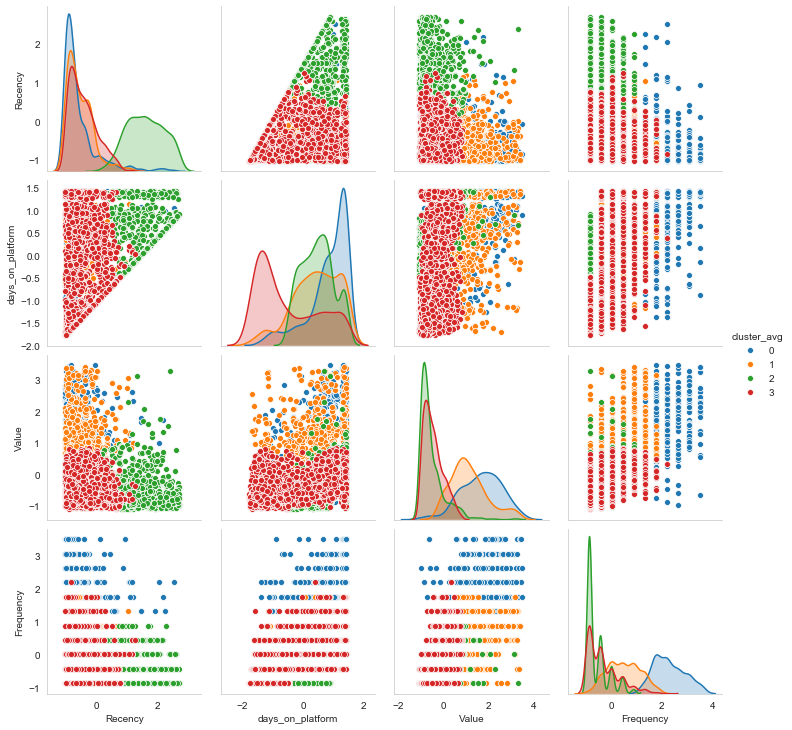

In [87]:
if_retail.cluster_avg.value_counts()

0    3156
3     102
1      73
2      42
Name: cluster_avg, dtype: int64

In [88]:
Should I do Agglomerative? How do i compare it with k-means. Face level the proportion of cluster is so scattered.

SyntaxError: invalid syntax (<ipython-input-88-c0937209698b>, line 1)

# Citations

Link - https://link.springer.com/article/10.1057%2Fdbm.2012.17
Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17

# Extras

### Segregating Outliers

Most popular ways are:
1. If the distribution is approximately Normal, mean +/- 2 standard deviation can be a good benchmark
2. Boxplot: Benchmark Q1-1.5*IQR and Q1+1.5*IQR
3. DBscan clustering as it partiotions out the noise points
4. Isolation Forest method by sklearn (a method similar in principle to Random Forest)

https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623
Here, is a nice resource by Will Badr that documents these methods.

In [30]:
Making quick Density plots

SyntaxError: invalid syntax (<ipython-input-30-fd2debe491a9>, line 1)

In [31]:
retail_3.dtypes

Recency               int64
days_on_platform      int64
Value               float64
Frequency             int64
dtype: object

In [32]:
# Removing outliers using Boxplot
df = retail_3
indexes_to_remove = []
for i in df.columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3-Q1
    b = df[(df[i] < Q1-1.5*IQR ) | (df[i] > Q3+1.5*IQR)].index.to_list()
    indexes_to_remove = indexes_to_remove + b

retail_4 = df.drop(set(indexes_to_remove))
retail_4 = retail_4

In [33]:
retail_3.shape

(3969, 4)

In [34]:
retail_4.shape

(3372, 4)

In [35]:
(retail_4.shape[0]-retail_3.shape[0])/retail_3.shape[0]

-0.15041572184429328

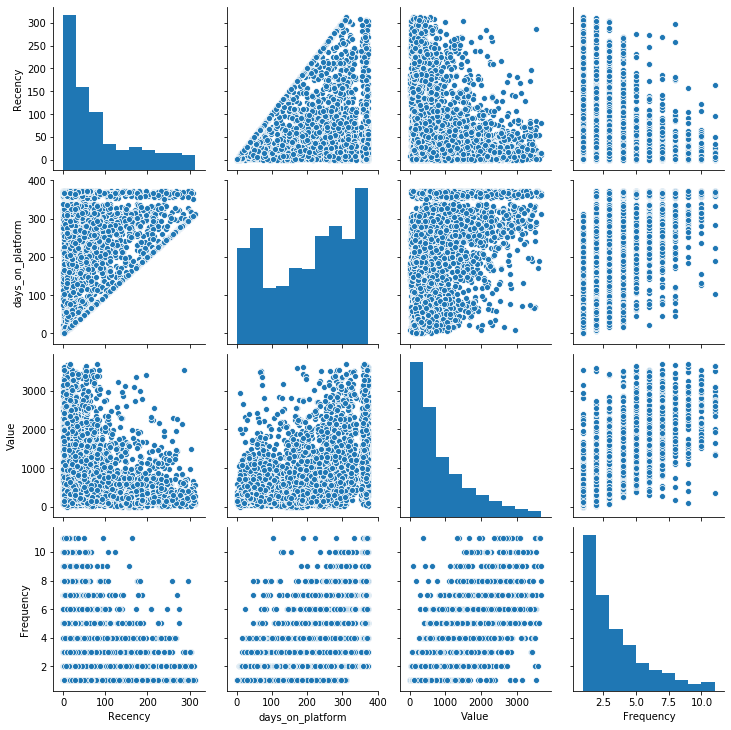

In [36]:
sns.pairplot(retail_4)

x% of the data has been removed for the clustering input. But these users maybe really important one.